In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.cuda.is_available()

True

In [4]:
import os
os.chdir("/content/drive/My Drive/SSNE_repo/SSNE/miniprojekt2")

In [5]:
device = torch.device("cuda") 
device

device(type='cuda')

In [6]:
torch.manual_seed(42)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [7]:
train_data = pd.read_csv('train_data.csv')

In [8]:
train_data['TimeToBusStop'] = train_data['TimeToBusStop'].map({'0~5min': 1, '5min~10min': 2, '10min~15min': 3})
train_data['TimeToSubway'] = train_data['TimeToSubway'].map({'0-5min': 1, '5min~10min': 2, '10min~15min': 3, '15min~20min': 4, 'no_bus_stop_nearby': 5})

In [9]:
train_data['class'] = pd.cut(x=train_data['SalePrice'], bins=[train_data['SalePrice'].min() - 1, 100000, 350000, train_data['SalePrice'].max() + 1], labels=[0,1,2])

In [10]:
train_data

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),class
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,2,3,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,1,2,2.0,2.0,Daegu,3,12.0,4.0,0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,1,2,2.0,2.0,Daegu,3,12.0,4.0,0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,1,1,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,2,4,4.0,8.0,Myung-duk,3,9.0,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,1,1,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,1,2,5.0,10.0,Daegu,7,7.0,11.0,1
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,1,1,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,1,1,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0,1


In [11]:
features = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)',  'N_manager',
       'N_elevators', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)',
       'TimeToBusStop', 'TimeToSubway']
cat_features = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
to_predict = ['class']

In [12]:
categorical_values = pd.get_dummies(train_data[cat_features])

In [13]:
train_indices = np.random.rand(len(train_data)) < 0.95

In [14]:
numerical_data = torch.from_numpy(train_data[features].values[train_indices]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(train_data[to_predict].values[train_indices].astype(np.dtype('int64')))

val_numerical_data = torch.from_numpy(train_data[features].values[~train_indices]).float()
val_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
val_targets = torch.from_numpy(train_data[to_predict].values[~train_indices].astype(np.dtype('int64')))

In [15]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
val_dataset = data.TensorDataset(val_numerical_data, val_categorical_data, val_targets)

In [16]:
train_data.columns

Index(['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor', 'HallwayType',
       'HeatingType', 'AptManageType', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'TimeToBusStop', 'TimeToSubway', 'N_manager',
       'N_elevators', 'SubwayStation', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)', 'class'],
      dtype='object')

In [17]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(27, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.act_1 =  nn.ReLU()
        self.d1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(50, 80)
        self.bn2 = nn.BatchNorm1d(80)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(80, 40)
        self.bn3 = nn.BatchNorm1d(40)
        self.act_3 = nn.ReLU()
        self.d3 = nn.Dropout(0.1)
        self.layer4 = nn.Linear(40, 12)
        self.bn4 = nn.BatchNorm1d(12)
        self.act_4 = nn.ReLU()
        self.d4 = nn.Dropout(0.1)
        self.layer5 = nn.Linear(12, 3)
        self.act_5 = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        # print(x)
        x = self.d1(self.act_1(self.bn1(self.layer1(x))))
        x = self.d2(self.act_2(self.bn2(self.layer2(x))))
        x = self.d3(self.act_3(self.bn3(self.layer3(x))))
        x = self.d4(self.act_4(self.bn4(self.layer4(x))))
        x = self.layer5(x)
        # x = self.softmax(x)
        return x

In [18]:
model = Classifier()

In [19]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # moving to device
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)

        output = model(x, cat_x)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [20]:
def train(model, train, valid, batch_size=64, num_epochs=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    epochs, losses, train_acc, val_acc = [], [], [], []

    # training
    model = model.to(device)

    for n in range(num_epochs):
        epoch_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        printing = True
        for x, cat_x, labels in iter(train_loader):
            model.train()
            # moving to GPU
            x = x.to(device)
            cat_x = cat_x.to(device)
            labels = labels.to(device)
            out = model(x, cat_x).unsqueeze(dim=2)         # forward pass
            # print('OUT', out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            
            epoch_loss += float(loss)
            # losses.append(float(loss)/batch_size)        # compute *average* loss
            # train_acc.append(get_accuracy(model, train)) # compute training accuracy 
            # val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            train_accuracy += get_accuracy(model, train)
            val_accuracy += get_accuracy(model, valid)
            
            
        losses.append(epoch_loss/(batch_size * len(train_loader)))
        epochs.append(n)
        train_acc.append(train_accuracy/len(train_loader))
        val_acc.append(val_accuracy/len(train_loader))
        
        if n%10==0:
            print(f"Epoch {n}")
        
    
    plot_results(epochs, losses, train_acc, val_acc)

            

In [21]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
Epoch 400
Epoch 410
Epoch 420
Epoch 430
Epoch 440
Epoch 450
Epoch 460
Epoch 470
Epoch 480
Epoch 490
Epoch 500
Epoch 510
Epoch 520
Epoch 530
Epoch 540
Epoch 550
Epoch 560
Epoch 570
Epoch 580
Epoch 590
Epoch 600
Epoch 610
Epoch 620
Epoch 630
Epoch 640
Epoch 650
Epoch 660
Epoch 670
Epoch 680
Epoch 690
Epoch 700
Epoch 710
Epoch 720
Epoch 730
Epoch 740
Epoch 750
Epoch 760
Epoch 770
Epoch 780
Epoch 790
Epoch 800
Epoch 810
Epoch 820
Epoch 830
Epoch 840
Epoch 850
Epoch 860
Epoch 870
Epoch 880
Epoch 890
Epoch 900
Epoch 910
Epoch 920
Epoch 930
Epoch 940
Epoch 950
Epoch 960
Epoch 970
Epoch 980
Epoch 990


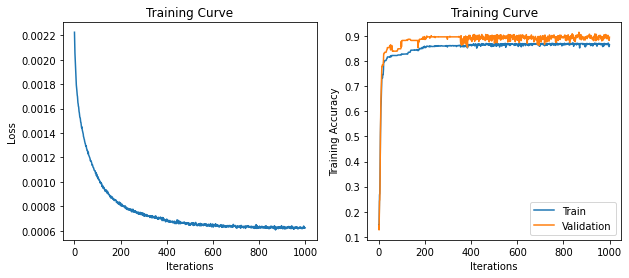

Final Training Accuracy: 0.8645540506005622
Final Validation Accuracy: 0.8945497630331753
CPU times: user 12min 26s, sys: 2.97 s, total: 12min 29s
Wall time: 12min 32s


In [22]:
%%time
train(model, train_dataset, val_dataset, num_epochs=1000, learn_rate=0.00012, weight_decay=0.02, batch_size=512)

In [23]:
# saving model to file
state_dict = model.state_dict()
torch.save(state_dict, "neural_net.tar")

In [24]:
# testing
test_data = pd.read_csv('test_data.csv')

In [25]:
test_data['TimeToBusStop'] = test_data['TimeToBusStop'].map({'0~5min': 1, '5min~10min': 2, '10min~15min': 3})
test_data['TimeToSubway'] = test_data['TimeToSubway'].map({'0-5min': 1, '5min~10min': 2, '10min~15min': 3, '15min~20min': 4, 'no_bus_stop_nearby': 5})

In [26]:
categorical_values_test = pd.get_dummies(test_data[cat_features])

In [27]:
numerical_data_test = torch.from_numpy(test_data[features].values).float()
categorical_data_test = torch.from_numpy(categorical_values_test.values).float()

In [28]:
numerical_data_test,categorical_data_test = numerical_data_test.to(device), categorical_data_test.to(device)

In [29]:
# predictions for test
pred = model(numerical_data_test, categorical_data_test)
pred = pred.max(1, keepdim=True)[1]

In [30]:
val_numerical_data, val_categorical_data = val_numerical_data.to(device), val_categorical_data.to(device)

In [31]:
# predictions for val
pred_val = model(val_numerical_data, val_categorical_data)
pred_val = pred_val.max(1, keepdim=True)[1]

In [32]:
# saving predictions to file
df_pred_val = pd.DataFrame(pred_val.cpu().numpy())
df_pred_val.to_csv('preds.csv', header=False, index=False)

In [33]:
# report for validation set
from sklearn.metrics import classification_report
print(classification_report(pred_val.cpu(), val_targets))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.94      0.92      0.93       158
           2       0.71      0.77      0.74        26

    accuracy                           0.90       211
   macro avg       0.83      0.86      0.84       211
weighted avg       0.90      0.90      0.90       211

